# **Analyzing Public Sentiment on CORETAX Implementation: Insights from X Posts**

Created by:
- Timothy Hartanto (Data Scientist)
- Yilmaz Trigumari Syah Putra (Data Scientist)
- Nabila Avicenna (Data Scientist)
- Muhammad Iqbal (Data Scientist)




## **Introduction**


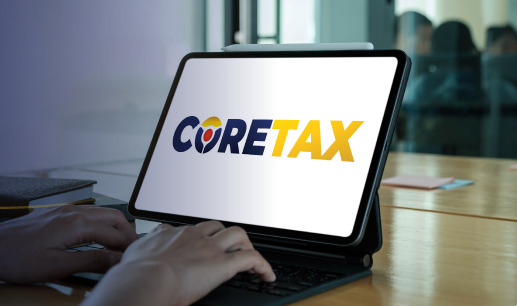

### **Background**

In early January, the Directorate General of Taxes (DGT) at Indonesia’s Ministry of Finance officially launched the Core Tax Administration System (CORETAX), an integrated, technology-based tax administration system. CORETAX is designed to streamline tax administration processes and enhance the tax database, aiming to improve efficiency, accuracy, and compliance in Indonesia’s tax ecosystem. Given the crucial role of taxation in national revenue, the successful implementation of this system is essential for both the government and taxpayers.

Despite its ambitious objectives and significant investment—amounting to IDR 1.3 trillion—CORETAX has encountered numerous technical issues and received substantial public criticism since its launch. Users have reported problems ranging from system errors, slow processing, and accessibility issues, raising concerns about the system’s effectiveness. Social media, particularly Twitter, has become a platform where taxpayers express their opinions, frustrations, and experiences regarding CORETAX. Understanding public sentiment towards CORETAX is crucial for evaluating its reception, identifying key concerns, and providing insights for future improvements.


### **Problem Statement**

How has the public responded to the implementation of CORETAX? Is public perception of CORETAX positive or negative?

### **Stakeholders**
The primary stakeholder of this project is **Director of Taxation Information and Technology (Direktur Teknologi Informasi Perpajakan - TIP)** within the **Indonesian Tax Ministry (Direktorat Jendral Pajak - DJP)** since the TIP department oversees the ongoing implementation of CORETAX and would likely be interested in public feedback.

### **Approach**

This study conducts sentiment analysis from scraped posts from the social media X to gauge public reaction to CORETAX. We collect tweets/posts related to "CORETAX" and classify them into binary (positive or negative) sentiments.

Natural Language Processing (NLP) methods, such as tokenization and sentiment classification, are used to identify the prevailing public mood and trend regarding CORETAX.

The results will provide insights into public perception and highlight areas for improvement.


## **Install and Import Libraries**

In [ ]:
# Import libraries
from google.colab import userdata

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
# import twint
import nest_asyncio
nest_asyncio.apply()

from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset, ClassLabel
import evaluate

import evaluate
import random

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

## **Scraping X for Posts about Coretax**



In this section, we collect tweets related to CORETAX using web scraping techniques. Our process involves the following steps:

- **Setting Up Twitter Account for Authentication**<br>
  We create a Twitter account to gain authentication token to gain access to the Twitter API, allowing us to retrieve relevant tweets about CORETAX.
- **Scraping Tweets Using TweetHarvest**<br>
  We use `TweetHarvest`, a Python-based scraping tool, to extract tweets containing keywords related to CORETAX. This ensures we gather a diverse range of public opinions, including complaints, feedback, and discussions.
- **Loading Data from Google Drive**<br>
  Once the tweets are collected, we store them in a .csv file and load it from Google Drive  for further analysis. This approach allows easy access and integration with our sentiment analysis workflow.

In [ ]:
# -------------------------------
# 1. Set Up Twitter Auth Token
# -------------------------------
# # calling twitter_auth_token from secrets
# twitter_auth_token = userdata.get('twitter_auth_token')

In [ ]:
# -------------------------------
# 2. Scrape Tweets Using tweet-harvest
# -------------------------------
# # Specify the path to your CSV file
# filename = 'coretax.csv'

# # Crawl Data
# search_keyword = 'coretax since:2025-01-01 until:2025-01-31 lang:id'
# limit = 500

# !npx -y tweet-harvest@2.6.1 -o f"{filename}" -s "{search_keyword}" --tab "LATEST" -l {limit} --token {twitter_auth_token}

In [ ]:
# -------------------------------
# 3. Load Data from Google Drive
# -------------------------------
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Read the CSV file into a pandas DataFrame
drive_path = '/content/drive/My Drive/coretax.csv'
tweets_data = pd.read_csv(drive_path, delimiter=",")
tweets = tweets_data[['id_str', 'username', 'created_at', 'full_text', 'retweet_count', 'favorite_count']]

# Display the DataFrame
display(tweets)

Mounted at /content/drive


,id_str,username,created_at,full_text,retweet_count,favorite_count
0,1891276121758667233,golkarpedia,Sun Feb 16 23:59:00 +0000 2025,Misbakhun Soal Coretax Sering Bermasalah: Hapu...,4,0
1,1891273979349881235,EkaWinahyu,Sun Feb 16 23:50:29 +0000 2025,@DitjenPajakRI Hai Mimin pajak error ini kenap...,0,0
2,1891273773036298535,SiMartabak,Sun Feb 16 23:49:40 +0000 2025,@kring_pajak mau bertanya kalau sebuah PT sebe...,0,0
3,1891273568081600529,pajakduri,Sun Feb 16 23:48:51 +0000 2025,#KawanPajak kini telah tersedia panduan Coreta...,0,1
4,1891231719816036803,dumboyeolie,Sun Feb 16 21:02:34 +0000 2025,Min berdasarkan info ini selanjutnya bikin fak...,0,0
...,...,...,...,...,...,...
1217,1889577853785948329,kring_pajak,Wed Feb 12 07:30:41 +0000 2025,@siegrienijekiel Hai Kak. Apakah data kompensa...,5,12
1218,1889577819325472810,kring_pajak,Wed Feb 12 07:30:33 +0000 2025,@ABukanbidadari Hai Kak. Mohon maaf atas ketid...,0,0
1219,1889577743706447896,kring_pajak,Wed Feb 12 07:30:15 +0000 2025,@putrilindion Hai Kak. Silakan melakukan perub...,0,0
1220,1889577488914796874,zilaf322,Wed Feb 12 07:29:14 +0000 2025,@kring_pajak min mau tnya knpa NIK nya tidak d...,0,0


Below is a description of the variables or columns found in the data.

| **Column Name**    | **Description**                                      |
|--------------------|--------------------------------------------------|
| **id_str**        | A unique identifier for each tweet.               |
| **username**      | The Twitter handle of the user who posted the tweet. |
| **created_at**    | The date and time when the tweet was posted.       |
| **full_text**     | The content of the tweet, used for sentiment analysis. |
| **retweet_count** | The number of times the tweet has been shared.     |
| **favorite_count**| The number of likes the tweet has received.        |


We shall filter out government X accounts (i.e. @kring_pajak or @pajakblampung2) from the scraped tweets.

In [ ]:
# eliminate government agencies (i.e. Kring Pajak) from the scraped Tweets
tweets = tweets[~tweets['username'].str.contains('pajak|djp', case=False, na=False)]

## **Data Cleaning & Preprocessing**

In this section, we clean and pre-process the collected tweets to prepare them for sentiment analysis.

The Data Cleaning consist of:
1. **Text Cleaning**: Removes mentions, hashtags, URLs, numbers, and punctuation
2. **Lowercase Conversion**: Makes all text lowercase
3. **Tokenization**: Split text into words
4. **Stopword Removal**: Removing common stop words in Indonesian
5. **Stemming**: Transform a word to its base form
6. **Reconstruct Sentence**: Concatenate stemmed words in a list from back into a sentence
7. **Removing Slang Words**: Changing slang words into standardized words based on KBBI

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
def removeSlangWords(text):
    slang_words = {
        'gk': 'gak',
        'ga': 'gak',
        'nggak': 'gak',
        'krn': 'karena',
        'knp': 'kenapa',
        'ap': 'apa',
        'tp': 'tapi',
        'bgt': 'banget',
        'bgd': 'banget',
        'bnget': 'banget',
        'gt': 'gitu',
        'jg': 'juga',
        'jgn': 'jangan',
        'skg': 'sekarang',
        'tdk': 'tidak',
        'gw': 'saya',
        'gue': 'saya',
        'lu': 'kamu',
        'lo': 'kamu',
        'nih': 'ini',
        'aja': 'saja',
        'klo': 'kalau',
        'dr': 'dari',
        'sm': 'sama',
        'knpa': 'kenapa',
        'ngapain': 'kenapa',
        'btw': 'by the way',
        'om': 'saya',
        'tante': 'saya',
        'mas': 'saya',
        'mba': 'saya',
        'bro': 'saya',
        'sis': 'saya',
        'kak': 'saya',
        'cuma': 'hanya',
        'abis': 'habis',
        'deh': '',
        'nih': 'ini',
        'dah': 'sudah',
        'udh': 'udah',
        'bener': 'benar',
        'bgtu': 'begitu',
        'bgtuh': 'begitu',
        'emg': 'memang',
        'sih': '',
        'dong': '',
        'jln': 'jalan',
        'gmn': 'bagaimana',
        'pokoknya': '',
        'jd': 'jadi',
        'w': 'saya',
        'aku': 'saya',
        'kamu': 'kamu',
        'kita': 'kami',
        'kalian': 'mereka',
        'mereka': 'mereka',
        'aja': 'saja',
        'yg': 'yang',
        'sdh': 'sudah',
        'jd': 'jadi',
        'klo': 'kalau',
        'dgn': 'dengan',
        'lg': 'lagi',
        'tau': 'tahu',
        'smua': 'semua',
        'bngt': 'banget',
        'bngtz': 'banget',
        'msk': 'masuk',
        'ad': 'ada',
        'dpt': 'dapat',
        'tdk': 'tidak',
        'msh': 'masih',
        'aja': 'saja',
        'jm': 'jam',
        'dlm': 'dalam',
        'utk': 'untuk',
        'lbh': 'lebih',
        'krja': 'kerja',
        'kyk': 'kayak',
        'pn': 'pun',
        'ktnya': 'katanya',
        'slh': 'salah',
        'bkn': 'bukan',
        'sy': 'saya',
        'sm': 'sama',
        'mlm': 'malam',
        'tuh': 'itu',
        'lbih': 'lebih',
        'dkit': 'sedikit',
        'mslh': 'masalah',
        'org': 'orang',
        'skali': 'sekali',
        'mreka': 'mereka',
        'emang': 'memang',
        'wktu': 'waktu',
        'bnyk': 'banyak',
        'mlh': 'malah',
        'dri': 'dari',
        'bbrp': 'beberapa',
        'tpi': 'tapi',
        'nnti': 'nanti',
        'si': '',
        'hehe': '',
        'hihi': '',
        'haha': '',
        'hooh': '',
        'hu': '',
        'wk': '',
        'wkwk': '',
        'hore': '',
        'yuhuu': ''
    }

    words = text.split()
    words = [slang_words[word] if word in slang_words else word for word in words]
    text = ' '.join(words)
    return text

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Preprocessing tweets data
import re

tweets['text_clean'] = tweets['full_text'].apply(cleaningText)
tweets['text_clean'] = tweets['text_clean'].apply(casefoldingText)
tweets.drop(['full_text'], axis = 1, inplace = True)

In [ ]:
import nltk
import os

nltk.data.path.append("nltk_data")

nltk.download('stopwords', download_dir="nltk_data")

print(nltk.data.find('corpora/stopwords'))

tweets['text_preprocessed'] = tweets['text_clean'].apply(tokenizingText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(filteringText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(stemmingText)

[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/content/nltk_data/corpora/stopwords


In [ ]:
tweets['text_preprocessed_sentence'] = tweets['text_preprocessed'].apply(toSentence)

In [ ]:
# drop duplicates/spams tweets
tweets.drop_duplicates(subset = 'text_clean', inplace = True)

In [ ]:
# Export to csv file
tweets.to_csv(r'coretax_clean.csv', index = False, header = True,index_label=None)

tweets

,id_str,username,created_at,retweet_count,favorite_count,text_clean,text_preprocessed,text_preprocessed_sentence
0,1891276121758667233,golkarpedia,Sun Feb 16 23:59:00 +0000 2025,4,0,misbakhun soal coretax sering bermasalah hapus...,"[misbakhun, coretax, masalah, hapus, sanksi, d...",misbakhun coretax masalah hapus sanksi ditjen ...
1,1891273979349881235,EkaWinahyu,Sun Feb 16 23:50:29 +0000 2025,0,0,hai mimin pajak error ini kenapa ya kami sudah...,"[hai, mimin, pajak, error, ya, minggu, bayar, ...",hai mimin pajak error ya minggu bayar pph reka...
2,1891273773036298535,SiMartabak,Sun Feb 16 23:49:40 +0000 2025,0,0,pajak mau bertanya kalau sebuah pt sebelumnya ...,"[pajak, pt, milik, npwp, beda, pabrik, lapor, ...",pajak pt milik npwp beda pabrik lapor pph pega...
4,1891231719816036803,dumboyeolie,Sun Feb 16 21:02:34 +0000 2025,0,0,min berdasarkan info ini selanjutnya bikin fak...,"[min, dasar, info, bikin, faktur, tetep, coret...",min dasar info bikin faktur tetep coretax eman...
5,1891189331307397410,d380no,Sun Feb 16 18:14:07 +0000 2025,0,0,ri iya harusnya kaya coretax habis trilyun ...,"[ri, iya, kaya, coretax, habis, trilyun, tp, b...",ri iya kaya coretax habis trilyun tp bingung y...
...,...,...,...,...,...,...,...,...
1191,1889583776499441830,di_bulibuli,Wed Feb 12 07:54:13 +0000 2025,0,0,pajak akun coretax ini apakah menggunakan id d...,"[pajak, akun, coretax, id, sandi, website, djp]",pajak akun coretax id sandi website djp
1193,1889583702318915905,bambangari28263,Wed Feb 12 07:53:56 +0000 2025,0,0,trilyun untuk membangun coretax tapi ternyata ...,"[trilyun, bangun, coretax, gagal, ditjen, paja...",trilyun bangun coretax gagal ditjen pajak sist...
1197,1889583469509951954,gloriafiliae,Wed Feb 12 07:53:00 +0000 2025,0,0,halo min pajak saya mau daftarkan pengguna bar...,"[halo, min, pajak, daftar, guna, coretax, bada...",halo min pajak daftar guna coretax badan cv no...
1213,1889578005569159545,lachibolalast,Wed Feb 12 07:31:17 +0000 2025,0,1,pajak mau buat npwp baru dari coretax tp ketik...,"[pajak, npwp, coretax, tp, masuk, nik, tera, n...",pajak npwp coretax tp masuk nik tera nomor ide...


## **Labelling the Dataset with Sentiment Polarity using Indonesian Lexicon**

In this step, we shall label the sentiment of the preprocessed tweets by assigning sentiment polarity scores based on an Indonesian lexicon.

Sentiment polarity refers to whether a tweet is positive, negative, or neutral. By using a predefined Indonesian lexicon that associates Indonesian words with either positive or negative sentiment scores, we can calculate an overall sentiment score and assign a label based on said calculation for each tweet.


In [ ]:
# Using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)
positive=pd.read_csv('/content/drive/My Drive/positive.tsv',sep='\t',header=1)
negative=pd.read_csv('/content/drive/My Drive/negative.tsv',sep='\t',header=1)
positive.to_csv('positive.csv',index=False)
negative.to_csv('negative.csv',index=False)
display(positive, negative)

,hai,3
0,merekam,2
1,ekstensif,3
2,paripurna,1
3,detail,2
4,pernik,3
...,...,...
3603,melarikan,3
3604,vakansi,3
3605,spesial,4
3606,asrama,3


,putus tali gantung,-2
0,gelebah,-2
1,gobar hati,-2
2,tersentuh (perasaan),-1
3,isak,-5
4,larat hati,-3
...,...,...
6603,kantong kering,-4
6604,penggaruk,-3
6605,senewen,-4
6606,menetapkan,-5


In [ ]:
lexicon_positive = dict()
import csv
with open('positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])


def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    else:
        polarity = 'negative'
    return score, polarity

In [ ]:
results = tweets['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets['polarity_score'] = results[0]
tweets['polarity'] = results[1]
print(tweets['polarity'].value_counts())

polarity
negative    507
positive    108
Name: count, dtype: int64


In [ ]:
tweets.to_csv(r'coretax_clean_polarity.csv', index = False, header = True,index_label=None)

tweets

,id_str,username,created_at,retweet_count,favorite_count,text_clean,text_preprocessed,text_preprocessed_sentence,polarity_score,polarity
0,1891276121758667233,golkarpedia,Sun Feb 16 23:59:00 +0000 2025,4,0,misbakhun soal coretax sering bermasalah hapus...,"[misbakhun, coretax, masalah, hapus, sanksi, d...",misbakhun coretax masalah hapus sanksi ditjen ...,-12,negative
1,1891273979349881235,EkaWinahyu,Sun Feb 16 23:50:29 +0000 2025,0,0,hai mimin pajak error ini kenapa ya kami sudah...,"[hai, mimin, pajak, error, ya, minggu, bayar, ...",hai mimin pajak error ya minggu bayar pph reka...,0,negative
2,1891273773036298535,SiMartabak,Sun Feb 16 23:49:40 +0000 2025,0,0,pajak mau bertanya kalau sebuah pt sebelumnya ...,"[pajak, pt, milik, npwp, beda, pabrik, lapor, ...",pajak pt milik npwp beda pabrik lapor pph pega...,1,positive
4,1891231719816036803,dumboyeolie,Sun Feb 16 21:02:34 +0000 2025,0,0,min berdasarkan info ini selanjutnya bikin fak...,"[min, dasar, info, bikin, faktur, tetep, coret...",min dasar info bikin faktur tetep coretax eman...,-8,negative
5,1891189331307397410,d380no,Sun Feb 16 18:14:07 +0000 2025,0,0,ri iya harusnya kaya coretax habis trilyun ...,"[ri, iya, kaya, coretax, habis, trilyun, tp, b...",ri iya kaya coretax habis trilyun tp bingung y...,-5,negative
...,...,...,...,...,...,...,...,...,...,...
1191,1889583776499441830,di_bulibuli,Wed Feb 12 07:54:13 +0000 2025,0,0,pajak akun coretax ini apakah menggunakan id d...,"[pajak, akun, coretax, id, sandi, website, djp]",pajak akun coretax id sandi website djp,-3,negative
1193,1889583702318915905,bambangari28263,Wed Feb 12 07:53:56 +0000 2025,0,0,trilyun untuk membangun coretax tapi ternyata ...,"[trilyun, bangun, coretax, gagal, ditjen, paja...",trilyun bangun coretax gagal ditjen pajak sist...,-23,negative
1197,1889583469509951954,gloriafiliae,Wed Feb 12 07:53:00 +0000 2025,0,0,halo min pajak saya mau daftarkan pengguna bar...,"[halo, min, pajak, daftar, guna, coretax, bada...",halo min pajak daftar guna coretax badan cv no...,-6,negative
1213,1889578005569159545,lachibolalast,Wed Feb 12 07:31:17 +0000 2025,0,1,pajak mau buat npwp baru dari coretax tp ketik...,"[pajak, npwp, coretax, tp, masuk, nik, tera, n...",pajak npwp coretax tp masuk nik tera nomor ide...,-2,negative


## **Exploratory Data Analysis (EDA) of Polarity Sentiment**

After labelling our dataset, we shall conduct Exploratory Data Analysis to gain a better understanding of our tweets dataset.

Firstly,  we use Latent Dirichlet Allocation (LDA) to uncover hidden topics in the tweets. To begin the LDA visualization, we create a dictionary that maps each unique word in the tweets to an ID. Then, we convert the preprocessed text into a bag-of-words format, which represents each tweet by counting the occurrence of each word. We train the LDA model with the corpus and dictionary, specifying 5 topics.

To evaluate the model, we calculate a coherence score, which measures how meaningful the topics are. The results, including the coherence score, are stored in a DataFrame. Finally, we visualize the topics using pyLDAvis, which helps us better understand the main themes in the tweets about CORETAX.

In [ ]:
dictionary = corpora.Dictionary(tweets['text_preprocessed'])
corpus = [dictionary.doc2bow(text) for text in tweets['text_preprocessed']]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)
coherence_model = CoherenceModel(model=lda_model, texts=tweets['text_preprocessed'], dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
topics_df = pd.DataFrame(columns=['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'])
topics_df.loc[0] = ['coretax_clean_polarity.csv', 5, 'auto', 'auto', coherence]
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

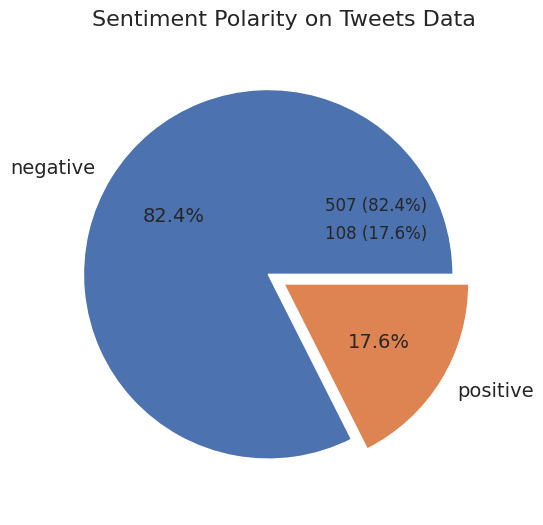

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
counts = tweets['polarity'].value_counts()
labels = list(counts.index)
sizes = list(counts.values)
explode = (0.1, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data', fontsize=16, pad=20)

total = sum(sizes)
for i, size in enumerate(sizes):
    percentage = size / total * 100
    ax.text(x=0.5, y=0.4-i*0.15, s=f'{size} ({percentage:.1f}%)', fontsize=12, ha='center')

plt.show()

By matching words in each tweet to a predefined lexicon of positive and negative words, we determined the sentiment polarity of each post. The results are visualized in a pie chart, showing that 82.4% of the tweets express negative sentiment, indicating significant dissatisfaction or frustration from users, with the remaining 17.6%  of the tweets expressing positive sentiments. These findings highlight the public's overall concerns regarding CORETAX and emphasize the need for further investigation into the issues users are facing.

To further illustrate the sentiment analysis results, we present examples of tweets categorized as positive and negative based on the Indonesian lexicon-based sentiment analysis.

In [ ]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:30]

,text_clean,polarity_score,polarity
1,hai open jasa lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan npwp tanggapan spdk konsultasi perpajakan pembuatan laporan keuangan pembuatan lapkeu spt lapor spt masa baca bio sebelum order ya kaa,23,positive
2,hello open jasa konsultasi perpajakan pembuatan laporan keuangan pembuatan lapkeu spt lapor spt masa lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan npwp tanggapan spdk sebelum order baca bio ya ka,22,positive
3,hi open jasa pembuatan npwp tanggapan spdk konsultasi perpajakan pembuatan laporan keuangan lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan lapkeu spt lapor spt masa baca bio terlebih dahulu sebelum order ya,21,positive
4,sore open jasa perhitungan pajak pembuatan npwp tanggapan spdk pembuatan laporan keuangan pembuatan laporan keuangan lapor spt lapor spt masa lapor spt tahunan pegawai pt cv badan baca bio terlebih dahulu sebelum order ya,21,positive
5,allow open jasa lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan npwp tanggapan spdk konsultasi perpajakan pembuatan laporan keuangan pembuatan lapkeu spt lapor spt masa sebelum order baca bio ya ka,20,positive
6,hallow open jasa pembuatan laporan keuangan pembuatan lapkeu spt lapor spt masa lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan npwp tanggapan spdk konsultasi perpajakan baca bio sebelum order ya,20,positive
7,sore open jasa pembuatan laporan keuangan spt lapor spt masa lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan npwp tanggapan spdk pembuatan laporan keuangan baca bio terlebih dahulu sebelum order ya kak,19,positive
8,pajak transaksi selain barang mewah kak namun dpp pada dokumen ppbj adalah bukan dpp nilai lain apakah saat buat faktur pajak harus disesuaikan manual untuk dpp nilai lainnya karena detail transaksi di coretax sudah otomatis hanya saja perhitungan ppn nya jadi beda,19,positive
9,malam open jasa pembuatan laporan keuangan lapor spt masa lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan npwp tanggapan spdk pembuatan laporan keuangan spt sebelum order baca bio terlebih dahulu ya ka,18,positive
10,hai open jasa pembuatan laporan keuangan spt lapor spt tahunan pegawai pt cv badan perhitungan pajak pembuatan npwp tanggapan spdk pembuatan laporan keuangan lapor spt masa baca bio terlebih dahulu sebelum order yaa,18,positive


In [ ]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_clean,polarity_score,polarity
1,coretax itu ajang mencuri amp merampok duit rakyat secara besaran hanya di nkri system pajak selalu berubah dgn tujuan mencari kesalahan rakyat wp rakyat wp pasti ada salah lha blm paham betul dgn system pajak baru eh sdh dirubahdiganti system baru itu celah utk pungli,-32,negative
2,daripada marah yeu kocak sbg pengguna coretax udah wajar bgt marah semua aplikasi pajak dijadiin satu website serentak di januari sosialisasi minim itu error tiap hari wasting time bgt kerjaan jd numpuk peduli bgt sama cari root cause error wkwk t bro,-31,negative
3,konyol bgt si prabowo kalau janji target pajak tapi masalah coretax sri mulyani ga bisa beresin dalam satu semester ini mah pecat aja menjabat cuma tahun kalau satu semester aja pendapatan pajak jeblok efeknya bisa berlarut larut apalagi sambil nombok utang jokowi,-29,negative
4,minimal sebagai drafter coretax bisa download bupot pph unifikasi masa kudu minta atasan perkara download doank hadeh mana lemot parah pajak,-28,negative
5,pajak hai kak mau tanya di sistem coretax apakah faktur pajak pengganti boleh beda tanggal dengan tanggal invoice seperti contoh kami membuat faktur pengganti di tanggal feb sedangkan masa januari maksimal di tanggal feb apakah boleh beda tanggal dengan invoice,-28,negative
6,fzn rakjel biasa yg mau taat pajak aja dipersulit gini coretax error terus web djp lama ga ada opsi taun giliran telat bayar pajak diuber dikasi denda macem kayak ngegarong duit negara,-28,negative
7,faktur pajak pengusaha kena pajak tertentu tetap dapat membuat faktur pajak dengan modul dalam portal wajib pajak pada sistem inti administrasi perpajakan coretax tanggal berlaku februari,-28,negative
8,hadapi rezim dalam sistem ppn di indonesia ikuti webinar ini perubahan skema ppn dan dampaknya penghitungan ppn terutang administrasi pajak faktur pajak nota pembatalan nota retur coretax djp pmk simak selengkapnya,-27,negative
9,pajak restitusi pajak dijamin balik nggak salah input pajak ppn spm kontrak katering baru sadar waktu udah jadi spd harusnya cuma pph keliru ketambahan ppn dokumen lampiran dll udah diserahkan kpp terkait terpaksa manual karena di coretax data ppn tidak ada,-27,negative
10,pajak yang error bukan browser kami bukan internet kami aplikasi coretax yang bermasalah udah pake incognito macam browser tetep aja error bad gateaway ini contohnya di inspect banyak manggil ip localhost pula ini gimana sihh,-26,negative


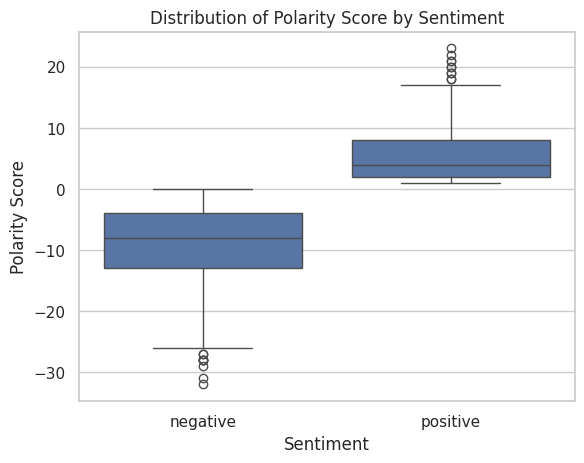

In [ ]:
sns.boxplot(x='polarity', y='polarity_score', data=tweets)
plt.xlabel('Sentiment')
plt.ylabel('Polarity Score')
plt.title('Distribution of Polarity Score by Sentiment')
plt.show()

To better understand the variation in sentiment scores, we visualize the distribution using a box plot. This helps identify how sentiment polarity is spread across the tweets.

- **Positive Sentiment**: The polarity scores for positive tweets show a wider range, with many values exceeding the upper bound (Q3 + IQR), making them appear as outliers. This suggests that when users express positivity, they tend to use highly positive language.

- **Negative Sentiment**: The distribution for negative tweets is more compact, with several values falling below the lower bound (Q1 - IQR), indicating strong negative sentiment in certain cases.

This distribution pattern suggests that while positive and negative tweets can be highly polarized, neutral tweets remain stable with little fluctuation.

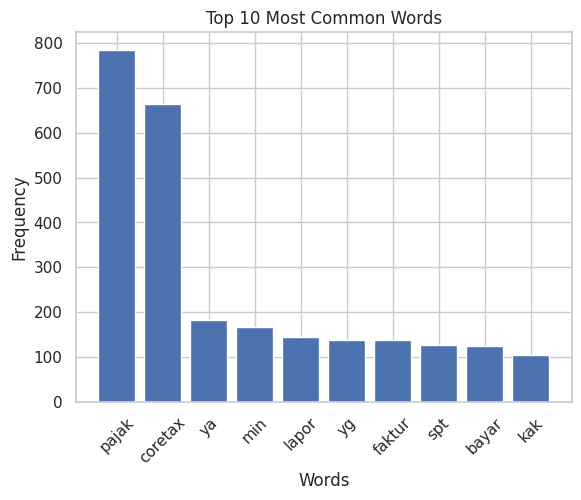

In [ ]:
from collections import Counter

all_words = ' '.join(' '.join(words) for words in tweets['text_preprocessed'])
word_counts = Counter(all_words.split())

top_words = word_counts.most_common(10)
labels, values = zip(*top_words)

plt.bar(labels, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

Analyzing the most frequently used words in the dataset helps us understand the key themes in discussions about CORETAX. The top 10 most common words are: "coretax," "kak," "pajak," "hai," "ya," "sila," "yg," "mohon," "akun," and "kakak."

- **"Coretax"** and **"pajak"** (tax) are expected, as they directly relate to the system and its purpose.
- **"Kak"** and **"kakak"** are commonly used in online interactions, especially when addressing customer service or asking for help.
- **"Hai"** and **"ya"** indicate conversational tones, possibly in greetings or confirmations.
- **"Sila"** and **"mohon"** (please) suggest that many tweets involve requests, likely directed at support or government representatives.
- **"Akun"** (account) hints at issues or discussions related to user accounts, such as login problems or account verification.
- **"Yg"** (short for **"yang"**) is a common Indonesian word used to connect phrases.


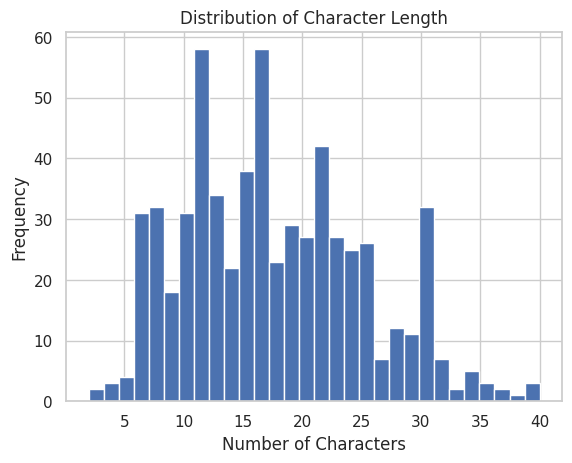

In [ ]:
tweet_lengths = tweets['text_preprocessed'].apply(len)

plt.hist(tweet_lengths, bins=30)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Character Length')
plt.show()

This histogram represents the distribution of character lengths in tweets related to CORETAX. The x-axis shows the number of characters in each tweet, while the y-axis represents the frequency of tweets with that length.

From the visualization, we observe that most tweets range between 5 to 30 characters, with peaks around 25 characters, indicating that many users are writing short, concise messages. There are also some shorter and longer tweets, but they occur less frequently. This distribution helps us understand the typical length of user interactions and how much information they convey in each tweet.

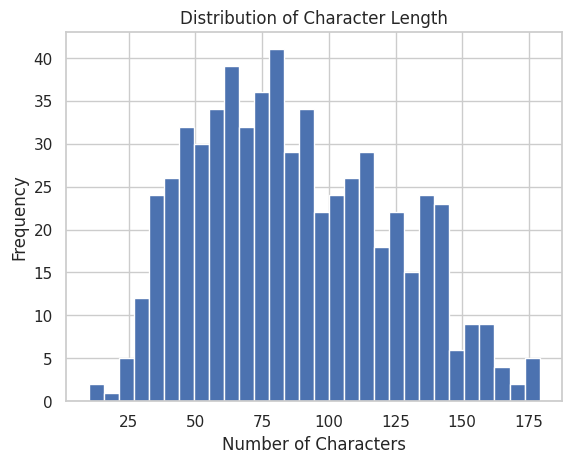

In [ ]:
from nltk import ngrams

# Distribusi Frekuensi Jumlah Huruf
tweet_lengths = tweets['text_preprocessed'].apply(lambda x: len(''.join(x)))

plt.hist(tweet_lengths, bins=30)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Character Length')
plt.show()

The histogram represents the distribution of character length in the dataset. The x-axis denotes the number of characters, while the y-axis represents the frequency of occurrences for different character lengths. The distribution appears to be fairly spread out, with some peaks around 35, 100, and 125 characters. This suggests that while there is some variability in text length, a significant portion of the dataset falls within these common length ranges. The presence of multiple peaks could indicate the presence of different categories of text within the dataset, possibly reflecting different writing styles or structural patterns.


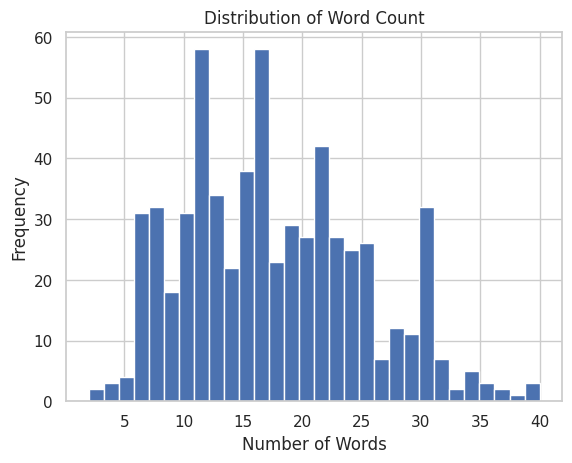

In [ ]:
# Distribusi Frekuensi Jumlah Kata
word_counts = tweets['text_preprocessed'].apply(len)

plt.hist(word_counts, bins=30)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

The histogram illustrates the distribution of text based on the number of words. Similar to the previous histogram, the x-axis represents the number of words, while the y-axis shows the frequency. The word count distribution exhibits a similar trend, with notable peaks around 10, 20, and 25 words. This suggests that the majority of the dataset consists of texts within this range. The presence of shorter and longer texts in the distribution indicates variability in sentence structure and content density.

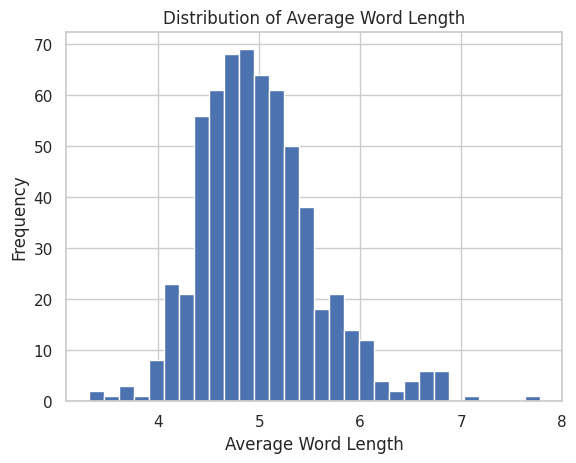

In [ ]:
# Distribusi Frekuensi Panjang Kata Rata-rata
average_word_lengths = tweets['text_preprocessed'].apply(lambda x: sum(len(word) for word in x) / len(x))

plt.hist(average_word_lengths, bins=30)
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Average Word Length')
plt.show()

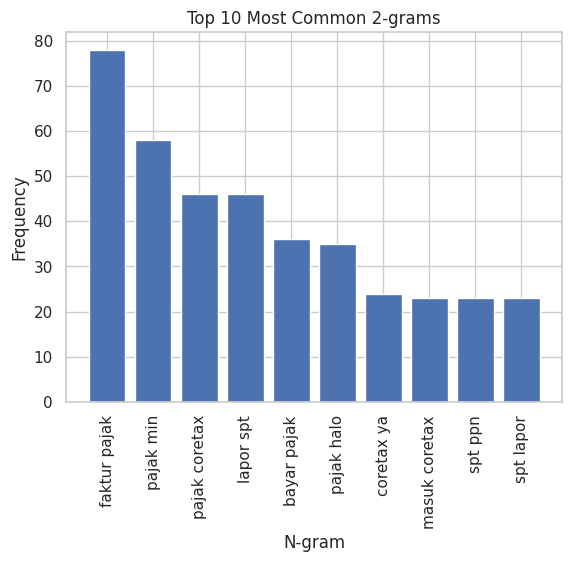

In [ ]:
# Distribusi Frekuensi N-gram
n = 2

ngram_counts = tweets['text_preprocessed'].apply(lambda x: list(ngrams(x, n)))
ngram_counts = [ngram for ngrams_list in ngram_counts for ngram in ngrams_list]

ngram_freq = Counter(ngram_counts)

labels, values = zip(*ngram_freq.most_common(10))
labels = [' '.join(label) for label in labels]

plt.bar(labels, values)
plt.xlabel('N-gram')
plt.ylabel('Frequency')
plt.title(f'Top 10 Most Common {n}-grams')
plt.xticks(rotation=90)
plt.show()

In our analysis of Twitter data related to "coretax," we identified the top 10 most common 2-grams, which are pairs of words that appear frequently together. These 2-grams highlight key topics and the tone of the conversation. Here's a simplified breakdown:

- **hai kak**: A casual greeting in Indonesian. "Hai" means "hi," and "kak" is a respectful term for someone slightly older or in a position of respect.
- **ya kak**: A polite affirmation, meaning "yes" or "okay," with "kak" used to show respect.
akun coretax: Refers to a "coretax account," indicating that users are discussing their accounts on the coretax platform.
- **mohon maaf**: A formal apology, meaning "I apologize" or "please forgive me," demonstrating politeness when addressing any issues.
- **kak mohon**: A respectful way of making a request, where "kak" shows respect and "mohon" means "please."
- **maaf ketidaknyamanannya**: A formal apology for any inconvenience caused, reflecting a concern for the user experience.
- **wajib pajak**: Refers to "taxpayer," indicating discussions about individuals or businesses obligated to pay taxes.
- **bukti potong**: Refers to a "tax certificate," a document showing tax deductions, relevant to the tax process.
- **faktur pajak**: Refers to a "tax invoice," a document commonly used in business transactions that involve taxes.
- **sistem coretax**: Refers to the "coretax system," the platform being discussed in relation to tax processing.

In our analysis, we generate a word cloud from the tweets data to visually represent the most frequent words in the text. A word cloud works by displaying words in different sizes, where the size of each word corresponds to how often it appears in the data. The more frequent a word is, the larger and bolder it appears in the cloud. This helps us quickly spot key topics or trends in the tweets, such as "coretax," "taxpayer," or "system." It's a simple and effective way to highlight the most important terms in a large set of text data.

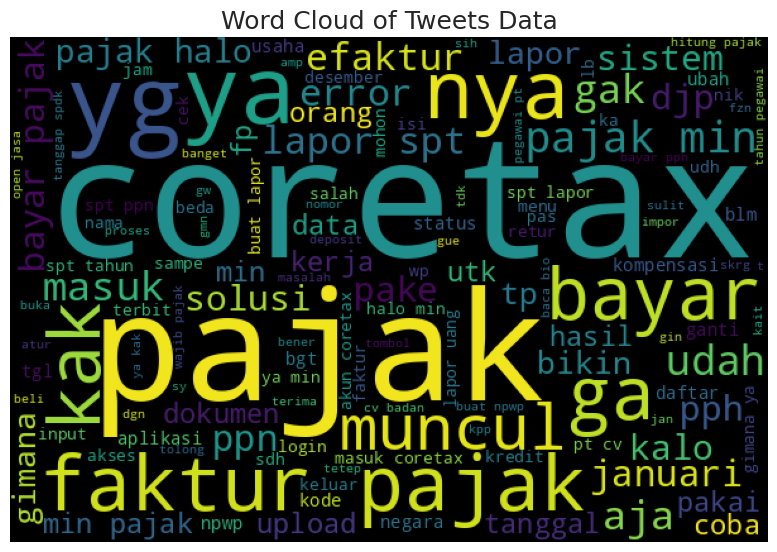

In [ ]:
list_words=''
for tweet in tweets['text_preprocessed']:
    for word in tweet:
        list_words += ' '+(word)

wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [ ]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]

        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)

    return positive_words, negative_words

In addition to the general word cloud, we also generate separate word clouds for positive and negative words based on the sentiment of the tweets.

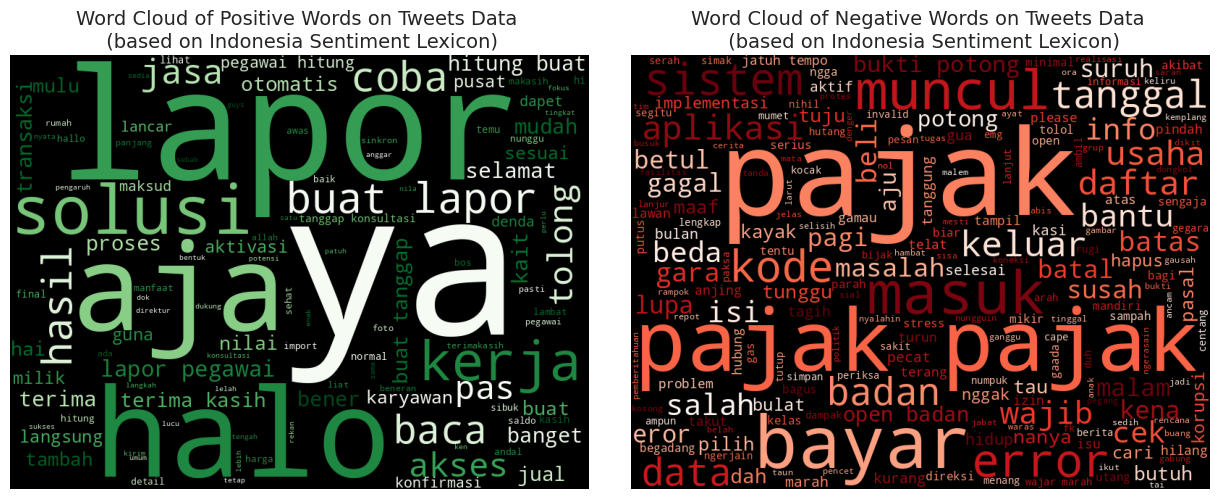

In [ ]:
# Visualize positive and negative word cloud

sentiment_words = tweets['text_preprocessed'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

## **Analysis with Large Language Model (LLM) from HuggingFace**



In this section, we are going to implement Natural Language Processing (NLP)  to classify tweet sentiment. For that purpose, we shall use the [indobert-base-p2 from huggingface](https://huggingface.co/indobenchmark/indobert-base-p2).

IndoBERT-base-2 is an improved version of the IndoBERT language model, specifically optimized for processing Indonesian text with enhanced contextual understanding and performance. Built upon the Bidirectional Encoder Representations from Transformers (BERT) architecture, IndoBERT-base-2 has been trained on a more diverse and extensive Indonesian corpus, making it highly effective for various(NLP) tasks, including sentiment analysis.

When applied to sentiment analysis of Coretax-related tweets, IndoBERT-base-2 can accurately classify sentiments by capturing nuanced expressions, slang, and contextual meanings specific to the Indonesian language. This is particularly valuable for analyzing public perception, user feedback, and concerns regarding Coretax, helping policymakers make data-driven decisions.

By fine-tuning IndoBERT-base-2 on our scraped tweets, it can improve its accuracy in classifying tweets into binary sentiment (positive/negative).

There are 7 steps that we shall conduct in the following code cells:
- **Step 1 - Modeling Preprocessing**: Conduct numerical encoding of the sentiment label and splitt the dataset into training/testing dataset to prepare the dataframe for tokenization.
- **Step 2 - Tokenization**: Convert text into tokenized input using IndoBERT-base-2's tokenizer, ensuring compatibility with the model's pre-trained vocabulary.
- **Step 3 - Model Initialization**: Load the IndoBERT-base-2 model with pre-trained weights and configure it for sentiment classification.
- **Step 4 - Training Setup**: Define the loss function, optimizer, and learning rate schedule to optimize the model's performance during training.
- **Step 5 - Hyperparameter Search**: Experiment with different hyperparameters (e.g., batch size, learning rate, dropout) to find the optimal settings for training IndoBERT-base-2.
- **Step 6 - Train the Model**: Train the IndoBERT-base-2 on labeled sentiment data by leveraging GPU acceleration for improved accuracy.
- **Step 7 - Evaluate the Model**: Assess the trained model's performance using accuracy, F1-score, and other metrics on a validation or test dataset.

### Step 1: Modelling Pre-Processing

In [ ]:
# Example: If 'polarity' column has strings like 'negative', 'neutral', 'positive',
# map them to integer labels for classification:
label2id = {'negative': 0, 'positive': 1}
tweets['label'] = tweets['polarity'].map(label2id)

# If there's any missing or invalid data, you can drop or filter:
tweets = tweets.dropna(subset=['text_preprocessed', 'label'])

# Show sample
tweets.head()

,id_str,username,created_at,retweet_count,favorite_count,text_clean,text_preprocessed,text_preprocessed_sentence,polarity_score,polarity,label
0,1891276121758667233,golkarpedia,Sun Feb 16 23:59:00 +0000 2025,4,0,misbakhun soal coretax sering bermasalah hapus sanksi ditjen pajak tanggung jawab,"[misbakhun, coretax, masalah, hapus, sanksi, ditjen, pajak, tanggung]",misbakhun coretax masalah hapus sanksi ditjen pajak tanggung,-12,negative,0
1,1891273979349881235,EkaWinahyu,Sun Feb 16 23:50:29 +0000 2025,0,0,hai mimin pajak error ini kenapa ya kami sudah minggu ini seperti ini dan tidak bisa melakukan pembayaran pph rekan rekan saya juga masih banyak yg tidak bis bayar pph solusi min kita ingin bayar tepat waktu tp kendala selalu di coretax,"[hai, mimin, pajak, error, ya, minggu, bayar, pph, rekan, rekan, yg, bis, bayar, pph, solusi, min, bayar, tp, kendala, coretax]",hai mimin pajak error ya minggu bayar pph rekan rekan yg bis bayar pph solusi min bayar tp kendala coretax,0,negative,0
2,1891273773036298535,SiMartabak,Sun Feb 16 23:49:40 +0000 2025,0,0,pajak mau bertanya kalau sebuah pt sebelumnya memiliki npwp yang berbeda pabrik untuk melaporkan pph pegawai apakah saat lapor di coretax bagian nitku pemotong diisi dengan nitku cabang atau tetap nitku pusat,"[pajak, pt, milik, npwp, beda, pabrik, lapor, pph, pegawai, lapor, coretax, nitku, potong, isi, nitku, cabang, nitku, pusat]",pajak pt milik npwp beda pabrik lapor pph pegawai lapor coretax nitku potong isi nitku cabang nitku pusat,1,positive,1
4,1891231719816036803,dumboyeolie,Sun Feb 16 21:02:34 +0000 2025,0,0,min berdasarkan info ini selanjutnya bikin faktur tetep masih bisa di coretax atau emang pindah ke efaktur client desktop pajak,"[min, dasar, info, bikin, faktur, tetep, coretax, emang, pindah, efaktur, client, desktop, pajak]",min dasar info bikin faktur tetep coretax emang pindah efaktur client desktop pajak,-8,negative,0
5,1891189331307397410,d380no,Sun Feb 16 18:14:07 +0000 2025,0,0,ri iya harusnya kaya coretax habis trilyun tp malah membingungkan yg mau bayar pajak,"[ri, iya, kaya, coretax, habis, trilyun, tp, bingung, yg, bayar, pajak]",ri iya kaya coretax habis trilyun tp bingung yg bayar pajak,-5,negative,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create a huggingface Dataset
dataset = Dataset.from_pandas(tweets[['text_preprocessed_sentence','label']])

In [ ]:
# Split into train/test
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = dataset['train']
test_ds  = dataset['test']

### Step 2: Tokenization

In [ ]:
# We'll use an Indonesian BERT model from Hugging Face ("indobenchmark/indobert-base-p2").
model_name = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text_preprocessed_sentence"], truncation=True)

train_ds = train_ds.map(preprocess_function, batched=True)
test_ds  = test_ds.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/492 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/123 [00:00<?, ? examples/s]

In [ ]:
# We'll set the format so that we get torch tensors back
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

### Step 3: Model Initialization

In [ ]:
num_labels = len(label2id)
id2label = {0: 'negative', 1: 'positive'}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 4: Training Setup

In [ ]:
batch_size = 16
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define metric calculation
accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1_pos_neg = f1_metric.compute(predictions=preds, references=labels, average='macro')
    return {
        "accuracy": acc["accuracy"],
        "f1_macro": f1_pos_neg["f1"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="results",
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

### Step 5: Hyperparameter Search

In [ ]:
# This will do a hyperparameter search on learning rate and number of epochs
# and select the best run based on 'accuracy'.
# For longer or more extensive searches, consider adjusting n_trials, param_space, etc.
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

trainer.model_init = model_init

In [ ]:
# Searching over a small parameter space for demonstration
# Increase n_trials or add more hyperparameters as needed
def my_objective(metrics):
    # The dictionary keys will usually be "eval_loss", "eval_accuracy", "eval_f1_macro", etc.
    return metrics["eval_accuracy"]

best_run = trainer.hyperparameter_search(
    direction="maximize",
    # Increase n_trials to explore more hyperparameter combinations
    n_trials=10,
    # Use Optuna-style hyperparameter definitions
    hp_space=lambda trial: {
        # Explore learning_rate across a broader range
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),

        # Vary the number of epochs
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),

        # Try different weight_decay values
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),

        # Tweak warmup_ratio (fraction of total steps spent warming up)
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),

        # Explore different batch sizes
        "per_device_train_batch_size": trial.suggest_categorical(
            "per_device_train_batch_size", [8, 16, 32]
        ),
    },
    compute_objective=my_objective
)

[I 2025-02-19 04:46:53,002] A new study created in memory with name: no-name-97f8cc93-4c50-4a52-83f4-7c85bb0c8e7d
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.534800,0.399221,0.845528,0.667520
2,0.354600,0.367361,0.837398,0.701456
3,0.231700,0.430661,0.804878,0.679130
4,0.145200,0.507140,0.813008,0.687231


[I 2025-02-19 04:48:15,715] Trial 0 finished with value: 0.8130081300813008 and parameters: {'learning_rate': 1.8285874417016047e-05, 'num_train_epochs': 4, 'weight_decay': 0.1275408279771274, 'warmup_ratio': 0.13918093205596677, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.8130081300813008.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.556700,0.382429,0.837398,0.455752
2,0.384200,0.368076,0.861789,0.729600
3,0.211600,0.579497,0.804878,0.679130
4,0.084400,0.519372,0.861789,0.729600
5,0.017600,0.556849,0.853659,0.731311


[I 2025-02-19 04:50:01,619] Trial 1 finished with value: 0.8536585365853658 and parameters: {'learning_rate': 4.4429565644608874e-05, 'num_train_epochs': 5, 'weight_decay': 0.04002162904492914, 'warmup_ratio': 0.1453037254620703, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.8536585365853658.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.734300,0.569129,0.837398,0.455752
2,0.533800,0.463001,0.837398,0.455752
3,0.467000,0.449080,0.837398,0.455752


[I 2025-02-19 04:51:09,958] Trial 2 finished with value: 0.8373983739837398 and parameters: {'learning_rate': 1.3975767429382066e-06, 'num_train_epochs': 3, 'weight_decay': 0.046194559225439254, 'warmup_ratio': 0.1492468151054472, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.8536585365853658.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.653400,0.437723,0.837398,0.455752
2,0.446600,0.397821,0.837398,0.455752
3,0.407000,0.387554,0.845528,0.505397
4,0.389200,0.382087,0.853659,0.550731


[I 2025-02-19 04:52:56,908] Trial 3 finished with value: 0.8536585365853658 and parameters: {'learning_rate': 2.4681331734055027e-06, 'num_train_epochs': 4, 'weight_decay': 0.27841569425152257, 'warmup_ratio': 0.1557882726653984, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.8536585365853658.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.473500,0.504295,0.723577,0.633415
2,0.346600,0.423069,0.780488,0.644927
3,0.204000,0.506046,0.788618,0.640189


[I 2025-02-19 04:54:42,904] Trial 4 finished with value: 0.7886178861788617 and parameters: {'learning_rate': 1.3949734213250913e-05, 'num_train_epochs': 3, 'weight_decay': 0.057432047075494486, 'warmup_ratio': 0.04485105989998235, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.8536585365853658.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.626700,0.444589,0.837398,0.455752
2,0.461600,0.413678,0.837398,0.455752
3,0.435100,0.406701,0.837398,0.455752


[I 2025-02-19 04:55:41,798] Trial 5 finished with value: 0.8373983739837398 and parameters: {'learning_rate': 1.0249087851119739e-06, 'num_train_epochs': 3, 'weight_decay': 0.20104294888006805, 'warmup_ratio': 0.11244692174740117, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.8536585365853658.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.720500,0.548898,0.837398,0.455752
2,0.519300,0.446005,0.837398,0.455752


[I 2025-02-19 04:56:01,142] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.693000,0.521182,0.837398,0.455752


[I 2025-02-19 04:56:07,499] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.571400,0.431421,0.869919,0.630631
2,0.406000,0.372517,0.869919,0.677588
3,0.317000,0.371369,0.853659,0.676694
4,0.289700,0.393948,0.829268,0.680045


[I 2025-02-19 04:57:27,072] Trial 8 finished with value: 0.8292682926829268 and parameters: {'learning_rate': 5.03907396916971e-06, 'num_train_epochs': 4, 'weight_decay': 0.19890265499821355, 'warmup_ratio': 0.18634150295482807, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.8536585365853658.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.600900,0.429085,0.837398,0.455752


[I 2025-02-19 04:57:33,663] Trial 9 pruned. 


In [ ]:
print("Best hyperparameters:", best_run.hyperparameters)

Best hyperparameters: {'learning_rate': 4.4429565644608874e-05, 'num_train_epochs': 5, 'weight_decay': 0.04002162904492914, 'warmup_ratio': 0.1453037254620703, 'per_device_train_batch_size': 32}


In [ ]:
# Update trainer with the best found hyperparameters
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

### Step 6: Train the Model

In [ ]:
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.556700,0.382429,0.837398,0.455752
2,0.384200,0.368076,0.861789,0.729600
3,0.211600,0.579497,0.804878,0.679130
4,0.084400,0.519372,0.861789,0.729600
5,0.017600,0.556849,0.853659,0.731311


TrainOutput(global_step=80, training_loss=0.2509175963699818, metrics={'train_runtime': 103.0633, 'train_samples_per_second': 23.869, 'train_steps_per_second': 0.776, 'total_flos': 56790876855360.0, 'train_loss': 0.2509175963699818, 'epoch': 5.0})

### Step 7: Evaluate the model

In [ ]:
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# Classification Report
# Map numeric labels back to original sentiment strings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label2id.keys())))
print(f"F1 Score: {f1_metric.compute(predictions=y_pred, references=y_true, average='macro')['f1']}")


Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.93      0.92       103
    positive       0.59      0.50      0.54        20

    accuracy                           0.86       123
   macro avg       0.75      0.72      0.73       123
weighted avg       0.85      0.86      0.86       123

F1 Score: 0.7296004138109402


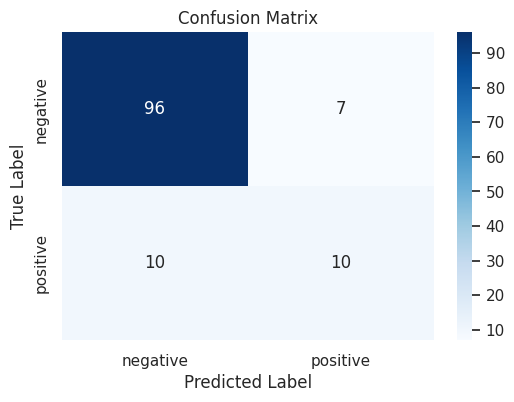

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Instantiate label names
label_names = ["negative", "positive"]  # or use id2label.values()

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Conclusion & Recommendation

## **Conclusion**
**1. Majority Sentiment is Negative**

* Lexicon-Based analysis indicates numerous complaints related to system errors, reporting issues, and user confusion.
* The IndoBERT model achieved 86% accuracy, but the recall for positive sentiment remains low (0.50), indicating a bias toward negative sentiment.

**2. Key Topics in the Data**

* Dominant words in EDA & WordCloud: "pajak" (tax), "coretax," "lapor" (report), "spt" (tax return), "bayar" (pay).
* The negative WordCloud displays words like "error," "gagal" (fail), "tidak bisa" (cannot), reinforcing the finding that technical issues are the main concern.
* The positive WordCloud is significantly smaller, often consisting of appreciation for smoothly functioning tax services.

## **Business Recommendation**
### **Coretax as an Online Tax System**

1. Optimize Coretax System & Services

  * Fix system bugs & errors to improve service stability.
  * Reevaluate the tax reporting flow to make it more intuitive and efficient.
  * Enhance customer support with faster responses to user complaints.

2. Increase Transparency & Communication

  * Use automated sentiment analysis to monitor user opinions in real-time.
  * Publish system updates & technical issue solutions to reduce user confusion.

### **Technology Perspective (NLP & IndoBERT)**

1. Sentiment Model Optimization

  * Perform dataset rebalancing & data augmentation to reduce negative sentiment bias.
  * Fine-tune IndoBERT with a broader tax-related dataset to improve accuracy.
  
2. NLP Implementation in Coretax Monitoring

  * Use IndoBERT for early detection of system issues through user complaint pattern analysis.
  * Implement a real-time sentiment dashboard for automatic monitoring of Coretax services.

### **General Recommendations for Digital Service Improvement**

1. Digital Tax Education & Literacy

  * Develop an interactive FAQ and AI chatbot to help users resolve technical issues.
  * Organize webinars & outreach programs to improve taxpayer understanding.

2. Continuous Sentiment Analysis

  * Conduct regular sentiment monitoring to measure the effectiveness of service improvements.
  * Integrate sentiment analysis results into Coretax's decision-making process.